In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import read_mist_models
import glob
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [3]:
data = np.loadtxt('NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt',usecols=(3,7),skiprows=1).T

In [4]:
# ignore that one weird data point at ~75mag in F606W-F814W. Why is it weird?
idx = np.argmax(data[0]-data[1])
data = np.delete(data,idx,axis=1)

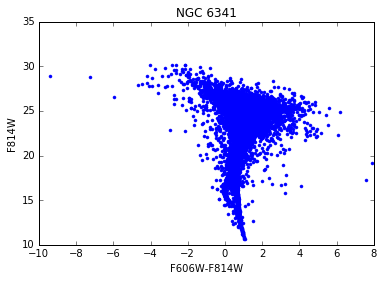

In [5]:
f,ax = plt.subplots()
ax.plot((data[0]-data[1]),data[1],'.')
ax.set_xlabel(r'F606W-F814W')
ax.set_ylabel(r'F814W')
ax.set_title('NGC 6341')

# Fitting MIST Isochrones

Synthetic Photometry data can be generated using MIST at different ages and metallicities. The resolution in metallicity in the Packaged Model Grids for the required HST filters (ACS_WFC_F606W and ACS_WFC_F814W) is much lower than what we want to fit for.

Using published literature, we know that M92 is an old (~14Gyr), metal poor (Fe/H ~ -2) cluster. To arrive at an age and metallicity for this cluster, it should be sufficient to iterate over values close to these predicted results. Hence, I only generated the isochrones for $-2.25 < Fe/H < -2.00$ and for $9.5< \log{age} < 10.3$. I also used the prior knowledge that Av = 0.034 for the I-band (NED).

In the following piece of code, I extracted the photometry data in the required two filters for the entire range of metallicities and ages, and put them into an accessible dictionary.

In [22]:
isochrones = {}
i = 0

for files in np.sort(glob.glob('MIST_iso_*')):
    z = 2 + i*0.05
    i+=1
    isochrones[z] = {}
    iso = read_mist_models.ISOCMD(files)

    for age in iso.ages:
        isochrones[z][age] = np.vstack((iso.isocmds[iso.age_index(age)]['ACS_WFC_F606W'], 
                                        iso.isocmds[iso.age_index(age)]['ACS_WFC_F814W']))

Reading in: MIST_iso_m200.iso.cmd
Reading in: MIST_iso_m205.iso.cmd
Reading in: MIST_iso_m210.iso.cmd
Reading in: MIST_iso_m215.iso.cmd
Reading in: MIST_iso_m220.iso.cmd
Reading in: MIST_iso_m225.iso.cmd


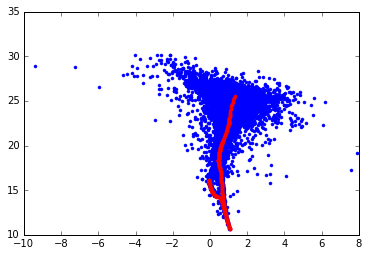

In [7]:
# For a random age, metallicity and distance plot the data and check if the extraction went as per expectation.

plt.plot((data[0]-data[1]),data[1],'b.')
# c = isochrones[2.15][10.3][0] - isochrones[2.15][10.3][1]
# m = isochrones[2.15][10.3][1] -5 + 5*np.log10(8.2*1e3)
plt.plot((isochrones[2.15][10.3][0] - isochrones[2.15][10.3][1]),
         (isochrones[2.15][10.3][1] -5 + 5*np.log10(8.2*1e3)),'r.')

Rather than using $\texttt{emcee}$ to fit for the age and metallicity, I decided to step through all the values. There are only 17 distinct $\log{age}$ values, 6 distinct $Fe/H$ values and 12 different ages, giving only 1224 unique combinations. Even with a 100 walkers and 10 steps (which might possible not be sufficient to converge), this is fewer steps than $\texttt{emcee}$ would take.

In [9]:
color = data[0]-data[1]
mag = data[1]

z = list(isochrones.keys())
np.sort(z)
age = iso.ages
D = np.arange(8,11,0.25)

lsq = np.zeros([np.size(z),np.size(age),np.size(D)])
print (np.shape(lsq))

for i,met in enumerate(z):
#     print (i,met)
    for j,ages in enumerate(age):
#         print (j,ages)
        c = isochrones[met][ages][0] - isochrones[met][ages][1]
        for k,dist in enumerate(D):
            m = np.copy(isochrones[met][ages][1])
            m += -5 + 5*np.log10(dist*1e3)
#             print (k,dist)

            ls = 0
            for l,x in enumerate(c):
                ls+= ((color-x)**2 + (mag-m[l])**2).min()
                
            lsq[i][j][k] = ls

#             f4,ax4 = plt.subplots(1,1)
#             ax4.plot((data[0]-data[1]),data[1],'b.')
#             ax4.plot(c,m,'r.')
            
#             break
#         break
#     break

#             if ls < deviation:
#                 z = met
#                 a = age
#                 d = distance

(6, 17, 12)


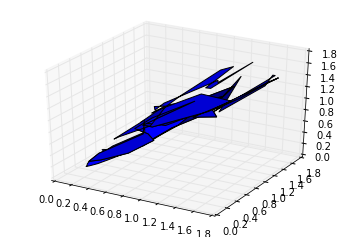

In [10]:
f1 = plt.figure()
ax1 = f1.add_subplot(111,projection='3d')
ax1.plot_surface(lsq[0],lsq[1],lsq[2])

In [11]:
idx = np.where(lsq == np.min(lsq))
z_final = z[idx[0][0]]
age_final = age[idx[1][0]]
dist_final = D[idx[2][0]]
print (z_final,age_final,dist_final)

2.25 10.15 9.0


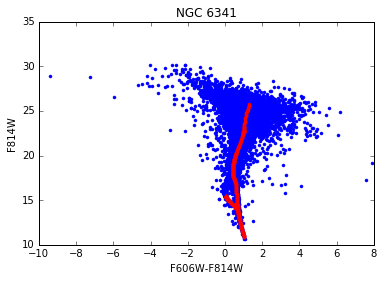

In [12]:
f2,ax2 = plt.subplots(1,1)
ax2.plot((data[0]-data[1]),data[1],'b.')
m = isochrones[z_final][age_final][1] -5 + 5*np.log10(dist_final*1e3)
ax2.plot((isochrones[z_final][age_final][0]-isochrones[z_final][age_final][1]),m,'r.')
ax2.set_xlabel(r'F606W-F814W')
ax2.set_ylabel(r'F814W')
ax2.set_title('NGC 6341')

# PARSEC Isochrone fitting

In [13]:
fe_h = np.arange(-2.25,-1.99,0.05)
z_sun = 0.0152
Z = z_sun*(10**fe_h)
print (Z)

[  8.54758814e-05   9.59055164e-05   1.07607759e-04   1.20737892e-04
   1.35470143e-04   1.52000000e-04]


In [21]:
parsec_isos = {}
i = 0

for files in np.sort(glob.glob('PARSEC_iso_*')):
    z = 2 + i*0.05
    i+=1
    parsec_isos[z] = {}
    iso = np.loadtxt(files,usecols=(1,13,18)).T

    for x,age in enumerate(iso[0]):
        parsec_isos[z][age] = np.vstack((iso[1],iso[2]))

In [25]:
parsec_isos[2.15].keys()

dict_keys([9.5, 10.1, 9.9000000000000004, 10.0, 9.5500000000000007, 9.5999999999999996, 10.050000000000001, 9.8000000000000007, 9.8499999999999996, 9.6500000000000004, 9.75, 9.6999999999999993, 9.9499999999999993])

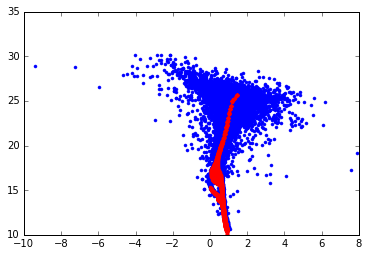

In [26]:
plt.plot((data[0]-data[1]),data[1],'b.')
# c = isochrones[2.15][10.3][0] - isochrones[2.15][10.3][1]
# m = isochrones[2.15][10.3][1] -5 + 5*np.log10(8.2*1e3)
plt.plot((parsec_isos[2.15][9.55][0] - parsec_isos[2.15][9.55][1]),
         (parsec_isos[2.15][9.55][1] -5 + 5*np.log10(8.2*1e3))+ 0.034,'r.')

In [27]:
z = list(parsec_isos.keys())
np.sort(z)
age = list(parsec_isos[2.15].keys())
np.sort(age)
D = np.arange(8,11,0.25)

lsq = np.zeros([np.size(z),np.size(age),np.size(D)])
print (np.shape(lsq))

for i,met in enumerate(z):
    for j,ages in enumerate(age):
        c = parsec_isos[met][ages][0] - parsec_isos[met][ages][1]
        for k,dist in enumerate(D):
            m = np.copy(parsec_isos[met][ages][1])
            m += -5 + 5*np.log10(dist*1e3) + 0.034

            ls = 0
            for l,x in enumerate(c):
                ls+= ((color-x)**2 + (mag-m[l])**2).min()
                
            lsq[i][j][k] = ls

#             f4,ax4 = plt.subplots(1,1)
#             ax4.plot((data[0]-data[1]),data[1],'b.')
#             ax4.plot(c,m,'r.')
            
#             break
#         break
#     break

#             if ls < deviation:
#                 z = met
#                 a = age
#                 d = distance

(5, 13, 12)


In [28]:
idx = np.where(lsq == np.min(lsq))
z_final = z[idx[0][0]]
age_final = age[idx[1][0]]
dist_final = D[idx[2][0]]
print (z_final,age_final,dist_final)

2.0 9.5 9.25


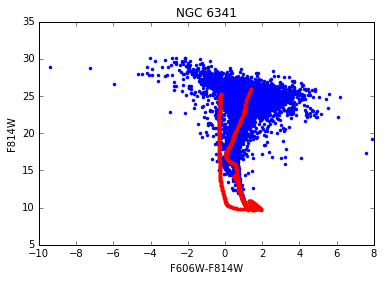

In [30]:
f3,ax3 = plt.subplots(1,1)
ax3.plot((data[0]-data[1]),data[1],'b.')
m = isochrones[z_final][age_final][1] -5 + 5*np.log10(dist_final*1e3) + 0.034
ax3.plot((isochrones[z_final][age_final][0]-isochrones[z_final][age_final][1]),m,'r.')
ax3.set_xlabel(r'F606W-F814W')
ax3.set_ylabel(r'F814W')
ax3.set_title('NGC 6341')